In [1]:
##DESCRIPTION
# This notebook calculates the so called "Polygons" to describe how a system under test reacts to a set of performance tests.


In [2]:
#install.packages("RColorBrewer", repos='http://cran.us.r-project.org')
#install.packages("gridExtra")
#install.packages("getPass")
#install.packages("RPostgreSQL")

library("RColorBrewer")
library(ggplot2)
library(gridExtra)
library(getPass)
library(RPostgreSQL)
library(dplyr)
library(stringr)

Loading required package: DBI


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
db_connection <- DBI::dbConnect(dbDriver(drvName = "PostgreSQL"), dbname = "pptam", host="db", port="5432", user="postgres", password="postgres")
dbGetQuery(db_connection, "SELECT id::text, name FROM projects") 

,id,name
,<chr>,<chr>
1,270ef577-5fbf-4200-a61c-46b6afebc74b,Demo Project
2,275b9bae-076d-446b-90a7-82328241d6b5,todolist


In [4]:
# Define the name of the project to analyze
project_name <- "todolist"

project_id = dbGetQuery(db_connection, str_glue("SELECT id::text FROM projects WHERE name='{project}'", project = project_name))$id

In [5]:
sql_operational_profile = "
    SELECT users, frequency FROM operational_profile_observations 
        WHERE operational_profile = (SELECT id FROM operational_profiles WHERE project = ?project)"
operational_profile <- dbGetQuery(db_connection, sqlInterpolate(db_connection, sql_operational_profile, project = project_id))

In [6]:
plot_width = 6
plot_height = 4
plot_font_size = 13

sql_all_data = "
    SELECT tests.name::text AS test_id, test_sets.name::text AS test_set_id, test_properties.value::numeric AS users, metrics.abbreviation AS metric, items.name AS item_name, results.value AS item_value
        FROM results 
        INNER JOIN tests ON results.test = tests.id
        INNER JOIN items ON results.item = items.id
        INNER JOIN test_properties ON (test_properties.test = tests.id AND test_properties.name = 'load')
        INNER JOIN metrics ON results.metric = metrics.id 
        INNER JOIN test_set_tests ON (test_set_tests.test = tests.id)
        INNER JOIN test_sets ON (test_sets.id = test_set_tests.test_set AND test_sets.project = tests.project)
        WHERE tests.project = ?project AND metrics.abbreviation IN ('art', 'sdrt', 'mix', 'fc', 'rc')"
all_data = dbGetQuery(db_connection, sqlInterpolate(db_connection, sql_all_data, project = project_id))


list_of_microservices = as.data.frame(unique(all_data[,5]))
no_of_microservices = nrow(list_of_microservices)

test_users_metric<-unique(all_data[,c(1:4)])


all_data$Endpoint = all_data$item_name
#all_data
plot_data <- all_data[all_data$metric == 'art',]
y_max = max(plot_data$item_value)
art_scaled = ggplot(data=plot_data[plot_data$test_set_id == 'scaled-cutoff',], aes(x = users, y = item_value, color=Endpoint)) + geom_line(aes(group = Endpoint)) + ylim(c(0,y_max)) + ylab('avg response time (ms)') + geom_point() + labs(title = 'Scaled Cutoff - Average Response Time') + theme_bw() + theme(text = element_text(size = plot_font_size))
art_fixed = ggplot(data=plot_data[plot_data$test_set_id == 'fixed-cutoff',], aes(x = users, y = item_value, color=Endpoint)) + geom_line(aes(group = Endpoint)) + ylim(c(0,y_max)) + ylab('avg response time (ms)') + geom_point() + labs(title = 'Fixed Cutoff - Average Response Time') + theme_bw() + theme(text = element_text(size = plot_font_size))
ggsave(plot=art_scaled, filename="art_scaled.png", width=plot_width, height=plot_height)
ggsave(plot=art_fixed, filename="art_fixed.png", width=plot_width, height=plot_height)

plot_data <- all_data[all_data$metric == 'sdrt',]
y_max = max(plot_data$item_value)
sdrt_scaled = ggplot(data=plot_data[plot_data$test_set_id == 'scaled-cutoff',], aes(x = users, y = item_value, color=Endpoint)) + geom_line(aes(group = Endpoint)) + ylim(c(0,y_max)) + ylab('sd response time (ms)') + geom_point() + labs(title = 'Scaled Cutoff - SD Response Time')+ theme_bw() + theme(text = element_text(size = plot_font_size))
sdrt_fixed = ggplot(data=plot_data[plot_data$test_set_id == 'fixed-cutoff',], aes(x = users, y = item_value, color=Endpoint)) + geom_line(aes(group = Endpoint)) + ylim(c(0,y_max)) + ylab('sd response time (ms)') + geom_point() + labs(title = 'Fixed Cutoff - SD Response Time')+ theme_bw() + theme(text = element_text(size = plot_font_size))
ggsave(plot=sdrt_scaled, filename="sdrt_scaled.png", width=plot_width, height=plot_height)
ggsave(plot=sdrt_fixed, filename="sdrt_fixed.png", width=plot_width, height=plot_height)

for(i in unique(all_data$test_id)) {
    for(j in unique(all_data$item_name)) {
        cur_set <- all_data[all_data$test_id == i & all_data$item_name == j,]
        fc <- cur_set[cur_set$metric == 'fc',]
        rc <- cur_set[cur_set$metric == 'rc',]
        fr <- fc$item_value / rc$item_value
        fc$metric = 'fr'
        fc$item_value = fr
        all_data = rbind(all_data, fc)
    }
}
#all_data

plot_data <- all_data[all_data$metric == 'fr',]
y_max = max(plot_data$item_value)
fr_scaled = ggplot(data=plot_data[plot_data$test_set_id == 'scaled-cutoff',], aes(x = users, y = item_value, color=Endpoint)) + geom_line(aes(group = Endpoint)) + ylim(c(0,y_max)) + ylab('failure rate') + geom_point() + labs(title = 'Scaled Cutoff - Failure Rate') + theme_bw() + theme(text = element_text(size = plot_font_size))
fr_fixed = ggplot(data=plot_data[plot_data$test_set_id == 'fixed-cutoff',], aes(x = users, y = item_value, color=Endpoint)) + geom_line(aes(group = Endpoint)) + ylim(c(0,y_max)) + ylab('failure rate') + geom_point() + labs(title = 'Fixed Cutoff - Failure Rate') + theme_bw() + theme(text = element_text(size = plot_font_size))
ggsave(plot=fr_scaled, filename="fr_scaled.png", width=plot_width, height=plot_height)
ggsave(plot=fr_fixed, filename="fr_fixed.png", width=plot_width, height=plot_height)

all_data[all_data$users == 1 & all_data$metric == 'fc',]

,test_id,test_set_id,users,metric,item_name,item_value,Endpoint
,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
252,todolist-scaled-cutoff-001,scaled-cutoff,1,fc,ToDo-Create,0,ToDo-Create
257,todolist-scaled-cutoff-001,scaled-cutoff,1,fc,ToDo-Delete,0,ToDo-Delete
262,todolist-scaled-cutoff-001,scaled-cutoff,1,fc,ToDo-Get-All,0,ToDo-Get-All
267,todolist-scaled-cutoff-001,scaled-cutoff,1,fc,ToDo-Get-Single,0,ToDo-Get-Single
272,todolist-scaled-cutoff-001,scaled-cutoff,1,fc,ToDo-Update,0,ToDo-Update


In [7]:
test_users_metric[list_of_microservices[,1]]<-NA

In [8]:
#If the tests occur too fast, it might be that some services have no data. This case is not handled, yet.

for (i in 1:nrow(test_users_metric)) {
    search_test_id <- test_users_metric[i,1]
    search_metric <- test_users_metric[i,4]
    
    for (j in 1:no_of_microservices) {
        search_microservice <- list_of_microservices[j,]
        
        row <- filter(all_data, test_id == search_test_id & metric == search_metric & item_name == search_microservice)
        
        if (dim(row)[1] > 0) {
            found_value = row$item_value
            
            if (length(found_value) == 1) {
                test_users_metric[i,j+4] <- found_value
            }
        }
    }
}
raw_data <- test_users_metric
raw_data


,test_id,test_set_id,users,metric,ToDo-Create,ToDo-Delete,ToDo-Get-All,ToDo-Get-Single,ToDo-Update
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,todolist-fixed-cutoff-010,fixed-cutoff,10,rc,116.0000000,65.00000000,114.0000000,233.0000000,193.0000000
2,todolist-fixed-cutoff-010,fixed-cutoff,10,fc,0.0000000,0.00000000,0.0000000,0.0000000,1.0000000
3,todolist-fixed-cutoff-010,fixed-cutoff,10,art,350.9913793,274.66153846,243.1578947,216.9484979,240.2487047
4,todolist-fixed-cutoff-010,fixed-cutoff,10,sdrt,44.4444444,39.25925926,29.4444444,40.0000000,41.4814815
5,todolist-fixed-cutoff-010,fixed-cutoff,10,mix,0.1608877,0.09015257,0.1581137,0.3231623,0.2676838
26,todolist-fixed-cutoff-020,fixed-cutoff,20,rc,240.0000000,123.00000000,237.0000000,473.0000000,386.0000000
27,todolist-fixed-cutoff-020,fixed-cutoff,20,fc,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000
28,todolist-fixed-cutoff-020,fixed-cutoff,20,art,150.3750000,183.21138211,182.7805907,150.8372093,152.1580311
29,todolist-fixed-cutoff-020,fixed-cutoff,20,sdrt,26.6666667,36.66666667,38.5185185,25.9259259,26.6666667


In [9]:
tests <- unique(raw_data[,1:3])

max_no_of_users <- max(raw_data[,3])
min_no_of_users <- min(raw_data[,3])

user_load <- operational_profile[,1]
user_load
access_count <- operational_profile[,2]
max_no_of_requests <- max(user_load)
scale_factor <- max_no_of_users/max_no_of_requests
scaled_user_load <- floor(scale_factor * user_load)
# Due to different profile, both are supposed to be the same
scaled_user_load <- user_load
scaled_user_load

[1]   0   1   2   3   4   5  10  11  12  13  15  16  17  18  19  20  21  22  23
[20]  24  25  26  27  28  30  35  40  42  45  50  55  60  65  70  75  80 105  85
[39]  90  95 100

[1]   0   1   2   3   4   5  10  11  12  13  15  16  17  18  19  20  21  22  23
[20]  24  25  26  27  28  30  35  40  42  45  50  55  60  65  70  75  80 105  85
[39]  90  95 100

In [10]:
##Create aggregate values (by fifty) of the user frequency from "operational_profile" 
steps <- 10

# calculate_aggregated_values <- function() {    
    access_frequency <- access_count/sum(access_count)
access_frequency
    by_fifty <- which((scaled_user_load %% steps) == 0)
by_fifty
    no_of_aggregated_rows = length(by_fifty)

    binProb <- c()
    for (i in 1:no_of_aggregated_rows) {
        if (i==1) {
            binProb[i] <- sum(access_frequency[1:by_fifty[i]])
        } else {
            binProb[i] <- sum(access_frequency[(by_fifty[i-1]+1):by_fifty[i]])
        }
    }

aggregated_values_from_operational_profile <- matrix(c(scaled_user_load[by_fifty], binProb), ncol=2, nrow=no_of_aggregated_rows, dimnames=list(c(1:no_of_aggregated_rows), c("Workload (number of users)", "Domain metric per workload")))
# }

# aggregated_values_from_operational_profile <- calculate_aggregated_values()
aggregated_values_from_operational_profile

[1] 0.007936508 0.029100529 0.015873016 0.015873016 0.015873016 0.021164021
 [7] 0.005291005 0.010582011 0.005291005 0.005291005 0.010582011 0.010582011
[13] 0.021164021 0.018518519 0.018518519 0.018518519 0.018518519 0.015873016
[19] 0.013227513 0.002645503 0.010582011 0.007936508 0.007936508 0.010582011
[25] 0.026455026 0.034391534 0.055555556 0.026455026 0.052910053 0.031746032
[31] 0.050264550 0.066137566 0.074074074 0.068783069 0.047619048 0.042328042
[37] 0.002645503 0.044973545 0.039682540 0.015873016 0.002645503

[1]  1  7 16 25 27 30 32 34 36 39 41

,Workload (number of users),Domain metric per workload
1,0,0.007936508
2,10,0.103174603
3,20,0.119047619
4,30,0.113756614
5,40,0.089947090
6,50,0.111111111
7,60,0.116402116
8,70,0.142857143
9,80,0.089947090
10,90,0.087301587


In [11]:
#Define the threshold for each service. The threshold is a vector computed as avg+3*SD for the configuration with 
#Users=2, Memory=4, CPU=1, CartReplica=1   

data_of_min_user<-raw_data[raw_data$users==min_no_of_users,]
test_of_min_user<-tests[tests$users==min_no_of_users,]

avg <-data_of_min_user[data_of_min_user$metric=="art",][,-c(1:4)]
sd <- data_of_min_user[data_of_min_user$metric=="sdrt",][,-c(1:4)]
threshold<-data.frame(test_of_min_user,avg+3*sd)

#Check the first line of the dataframe thereshold: it must be one line
head(threshold)
data_of_min_user

,test_id,test_set_id,users,ToDo.Create,ToDo.Delete,ToDo.Get.All,ToDo.Get.Single,ToDo.Update
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
251,todolist-scaled-cutoff-001,scaled-cutoff,1,299.0278,239.5,287.0833,269.9167,271.4444


,test_id,test_set_id,users,metric,ToDo-Create,ToDo-Delete,ToDo-Get-All,ToDo-Get-Single,ToDo-Update
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
251,todolist-scaled-cutoff-001,scaled-cutoff,1,rc,12.0000000,6.00000000,12.0000000,24.0000000,18.0000
252,todolist-scaled-cutoff-001,scaled-cutoff,1,fc,0.0000000,0.00000000,0.0000000,0.0000000,0.0000
253,todolist-scaled-cutoff-001,scaled-cutoff,1,art,197.9166667,191.16666667,198.7500000,183.2500000,192.5556
254,todolist-scaled-cutoff-001,scaled-cutoff,1,sdrt,33.7037037,16.11111111,29.4444444,28.8888889,26.2963
255,todolist-scaled-cutoff-001,scaled-cutoff,1,mix,0.1666667,0.08333333,0.1666667,0.3333333,0.2500


In [12]:
#Exclude case with user = 2 from dataFile and check whether each service passes or fail: avg<threshol (Pass). 
#Compute the relative mass for each configuration

tests_without_benchmark<-tests[!tests$users==min_no_of_users,]
raw_data_without_benchmark<-raw_data[!raw_data$users==min_no_of_users,]

avg<-raw_data_without_benchmark[raw_data_without_benchmark$metric=="art",-4]
sd<-raw_data_without_benchmark[raw_data_without_benchmark$metric=="sdrt",-4]
mix<-raw_data_without_benchmark[raw_data_without_benchmark$metric=="mix",-4]

#Check pass/fail for each service. the "mix" value is 0 if fail and mixTemp if pass. Compute the relative mass for each configuration
pass_criteria<-avg

calculate_relative_mass <- function() {    
    relative_mass<-c()

    mix_of_passing_tests<-as.data.frame(matrix(nrow=nrow(tests_without_benchmark), ncol=ncol(raw_data_without_benchmark)-1))

    for(j in 1:nrow(pass_criteria)){
        mix_of_passing_tests[j,]<-mix[j,]
        for(i in 3:(2+no_of_microservices)){
            if(pass_criteria[j,i]>threshold[i]){
                mix_of_passing_tests[j,i]<-0
            }
        }
        relative_mass[j]<-sum(mix_of_passing_tests[j,3:(2+no_of_microservices)])
    }
   
    relative_mass
}

relative_mass <- calculate_relative_mass()

#Show first lines of passCriteria
head(pass_criteria)

,test_id,test_set_id,users,ToDo-Create,ToDo-Delete,ToDo-Get-All,ToDo-Get-Single,ToDo-Update
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,todolist-fixed-cutoff-010,fixed-cutoff,10,350.9914,274.6615,243.1579,216.9485,240.2487
28,todolist-fixed-cutoff-020,fixed-cutoff,20,150.3750,183.2114,182.7806,150.8372,152.1580
53,todolist-fixed-cutoff-030,fixed-cutoff,30,143.2028,151.0652,164.5141,128.4278,139.3990
78,todolist-fixed-cutoff-040,fixed-cutoff,40,246.0343,268.5587,265.1727,236.3056,262.9556
103,todolist-fixed-cutoff-050,fixed-cutoff,50,295.2517,297.1827,212.7242,144.9492,274.9593
128,todolist-fixed-cutoff-060,fixed-cutoff,60,530.5685,485.1390,346.1750,235.2125,453.9842


In [13]:
#Compute the domain metric for each configuration
tests_without_benchmark$relative_mass<-relative_mass

absolute_mass<-c()
for(j in 1:nrow(tests_without_benchmark)) {
    absolute_mass[j]<-tests_without_benchmark[j,"relative_mass"]*aggregated_values_from_operational_profile[match(tests_without_benchmark[j,"users"], aggregated_values_from_operational_profile[,1]),2]
}
tests_without_benchmark$absolute_mass<-absolute_mass

test_sets<-as.data.frame(unique(all_data[,2]))
colnames(test_sets)[1] <- "test_set_id"

set<-list()
domain_metric_list<-list()
for(i in 1:nrow(test_sets)){
    set[[i]]<-tests_without_benchmark[which(tests_without_benchmark[,2] == test_sets[i,1]),]
    domain_metric_list[[i]]<-set[[i]][,c(3,5)][order(set[[i]][,c(3,5)][,1]),]
}

#Uncomment this to show first lines of domain_metric_list
#head(domain_metric_list)
domain_metric_list

,users,absolute_mass
,<dbl>,<dbl>
1,10,0.04965546
26,20,0.08755181
51,30,0.08285402
76,40,0.05838452
101,50,0.07174343
126,60,0.03772266
151,70,0.00000000
176,80,0.00000000
201,90,0.00000000


In [14]:
#Compute Cumulative Domain metric: summing up absoluteMass over users for each configuration
test_sets$domain_metric<-0
for(i in 1:nrow(test_sets)){
    test_sets[i,2]<-round(sum(tests_without_benchmark[which(tests_without_benchmark[,2] == test_sets[i,1]),"absolute_mass"]),4)
}
domain_metric<-test_sets

domain_metric

test_set_id,domain_metric
<chr>,<dbl>
fixed-cutoff,0.3879
scaled-cutoff,0.6630


,Workload (number of users),Domain metric per workload
1,0,0.007936508
2,10,0.103174603
3,20,0.119047619
4,30,0.113756614
5,40,0.089947090
6,50,0.111111111
7,60,0.116402116
8,70,0.142857143
9,80,0.089947090
10,90,0.087301587


1           2           3           4           5           6 
0.007936508 0.103174603 0.119047619 0.113756614 0.089947090 0.111111111

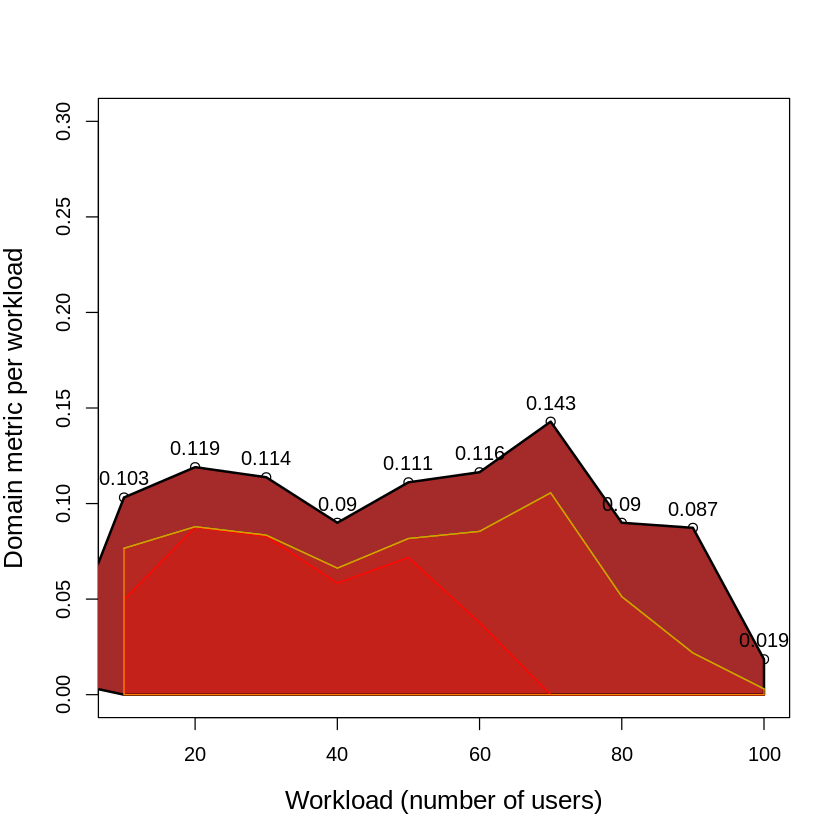

In [15]:
#Plot operational_profile against domain metric for each configuration

plot(aggregated_values_from_operational_profile, xlim=c(steps, max_no_of_users), ylim=c(0, 0.3),cex.lab=1.3)
polygon(c(steps,aggregated_values_from_operational_profile[,1],max_no_of_users),c(0,aggregated_values_from_operational_profile[,2],0), col="brown", lty = 1, lwd = 2, border = "black")
color=heat.colors(11)
color_transparent <- adjustcolor(color, alpha.f = 0.2) 

sorted_domain_metric<-domain_metric
k<-which(sorted_domain_metric[,2]==max(sorted_domain_metric[,2]))
#Green line whithin the polygon is the best domain matric line. 
#It corresponds to the second line in the final table below

for(i in 1:nrow(test_sets)) {
    lines(domain_metric_list[[i]], type="l", col=heat.colors(11)[i])    
    lines(domain_metric_list[[k]], type="l", col="green")
    polygon(c(steps,t(domain_metric_list[[i]][1]),max_no_of_users),c(0,t(domain_metric_list[[i]][2]),0), col=color_transparent[i], lty = 1, lwd = 1 , border = rainbow(11)[i])
}

text(aggregated_values_from_operational_profile,labels = round(aggregated_values_from_operational_profile[,2],3), pos=3, col="black")

graphics.off()
aggregated_values_from_operational_profile
aggregated_values_from_operational_profile[1:6,2]

In [16]:
DBI::dbDisconnect(db_connection)

[1] TRUE